# Иерархическая кластеризация

Данные столбцов:

- culmen_length_mm: длина верхнего края клюва пингвина (миллиметр)

- culmen_depth_mm: глубина верхнего края клюва пингвина (миллиметр)

- flipper_length_mm: длина ласт (миллиметр)

- body_mass_g: масса тела (грамм)

- sex: пол пингвина 

## Импортируем данные

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score, silhouette_score
import joblib

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('penguins.csv')
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


## Проведем EDA (Exploratory Data Analysis) - первичный анализ данных

In [4]:
# Функция для числовых столбцов
def eda_num_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Минимальное значение": df.min(),
            "Максимальное значение": df.max(),
            "Среднее значение": df.mean(),
            "Медиана": df.median(),
            "Дисперсия": df.var(),
            "Квантиль 0.1": df.quantile(0.1),
            "Квантиль 0.9": df.quantile(0.9),
            "Квартиль 1": df.quantile(0.25),
            "Квартиль 3": df.quantile(0.75)
        }
    )

    return x

In [5]:
# Функция для категориальных столбцов
def eda_cat_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Количество уникальных значений": df.nunique(),
            "Мода": df.mode().iloc[0]
        }
    )
    
    return x

In [6]:
col_num = df.select_dtypes(include=["number"]).columns
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.005814,32.1,59.6,43.921930,44.45,29.807054,36.6,50.8,39.225,48.50
culmen_depth_mm,0.005814,13.1,21.5,17.151170,17.30,3.899808,14.3,19.5,15.600,18.70
flipper_length_mm,0.005814,-132.0,5000.0,214.014620,197.00,67890.501252,185.0,221.0,190.000,213.75
body_mass_g,0.005814,2700.0,6300.0,4201.754386,4050.00,643131.077327,3300.0,5400.0,3550.000,4750.00


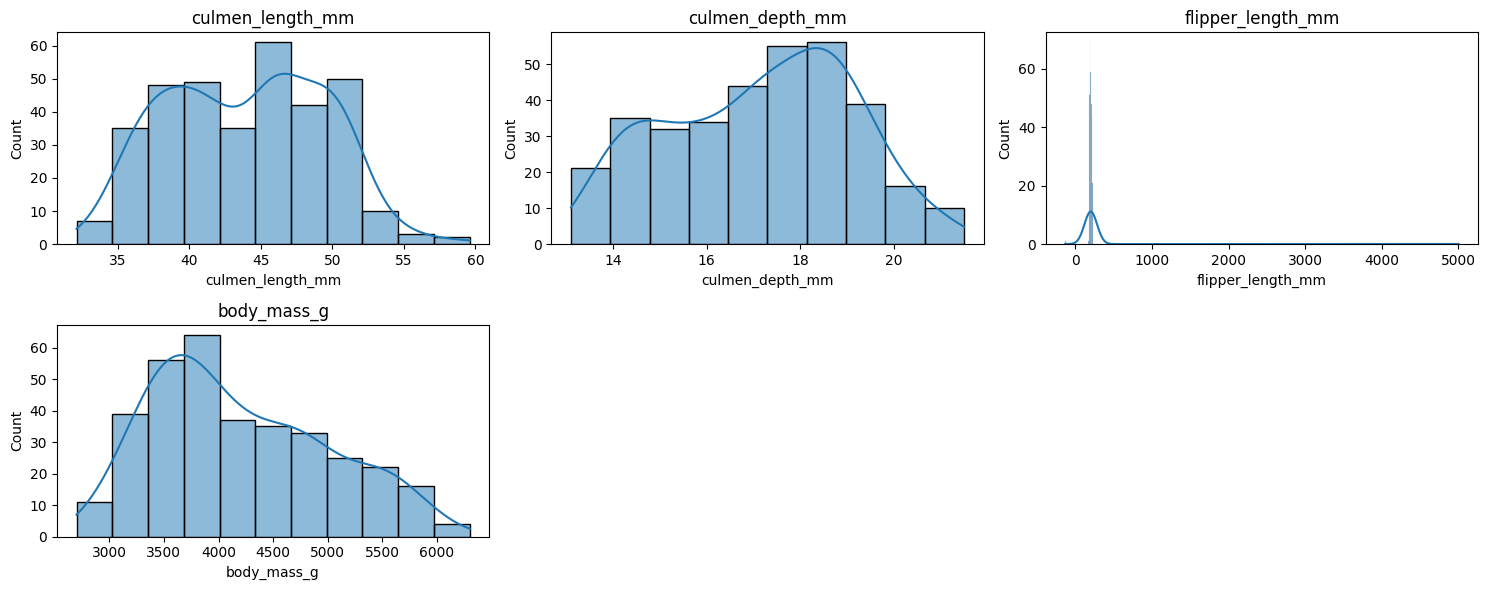

In [7]:
# Визуализация гистограмм
def plot_histograms(df):
    # Определить количество строк и столбцов для подграфиков
    n_cols = 3
    n_rows = (len(df.columns) + n_cols - 1) // n_cols
    
    # Создать фигуру с нужным размером
    plt.figure(figsize=(n_cols * 5, n_rows * 3))
    
    for i, column in enumerate(df.columns, start=1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[column], kde=True)
        
        # Добавить название столбца как заголовок графика
        plt.title(column)
        
    plt.tight_layout()
    plt.show()

# Применение функции к DataFrame df
plot_histograms(df[col_num])

Видим, что гистограмма длины ласт (*flipper_lenght_mm*) пингвинов имеет выбросы и отрицательные значения. Остальные данные в порядке.

In [8]:
col_cat = df.select_dtypes(include=["object"]).columns
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.026163,3,MALE


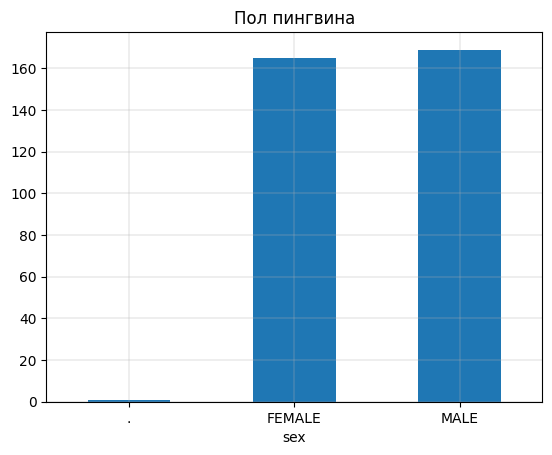

In [9]:
df['sex'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.grid(linewidth=0.3)
plt.title('Пол пингвина')
plt.show()

In [10]:
df['sex'].unique()

array(['MALE', 'FEMALE', nan, '.'], dtype=object)

In [11]:
df['sex'].value_counts()

sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

Видим, что помимо пропусков данных в столбце пола имеется аномалия - третье значение, обозначенное `.`. Заменим эту аномалию модой.

In [12]:
df['sex'].replace('.', df['sex'].mode()[0], inplace=True)

In [13]:
df['sex'].unique()

array(['MALE', 'FEMALE', nan], dtype=object)

In [14]:
df['sex'].value_counts()

sex
MALE      170
FEMALE    165
Name: count, dtype: int64

## Обработка пропусков

In [15]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
dtype: int64

Количество пропусков в категориальных столбцах:
sex    9
dtype: int64


In [16]:
# Заполняем пропуски числовых переменных медианой
df[col_num] = df[col_num].fillna(df[col_num].median())

In [17]:
# Заполненяем пропуски модой
for column in col_cat:
    mode_value = df[column].mode()[0]  # Получение моды
    df.fillna({column: mode_value}, inplace=True)  # Заполнение пропусков модой

In [18]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
dtype: int64

Количество пропусков в категориальных столбцах:
sex    0
dtype: int64


## Проверка на выбросы в данных

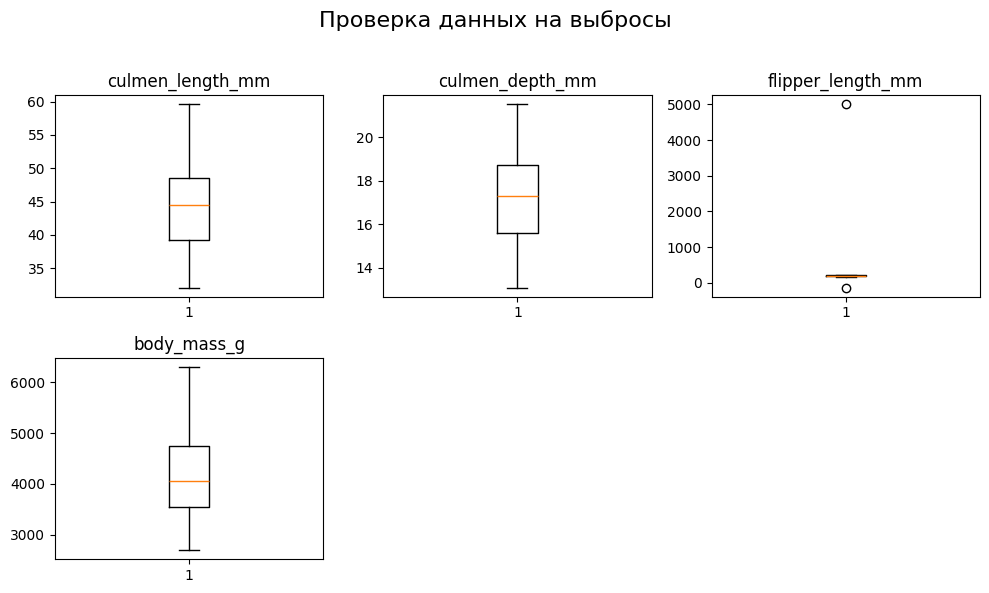

In [19]:
n = len(col_num)
ncols = 3  # Количество столбцов в сетке
nrows = (n + ncols - 1) // ncols  # Количество строк

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3 * nrows))
axes = axes.flatten()  # Преобразование в одномерный массив для удобства

# Создание boxplot для каждого числового столбца
for i, column in enumerate(col_num):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)  # Заголовок для каждого графика

# Удаление пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle("Проверка данных на выбросы", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Автоматическая настройка отступов
plt.show()  # Отображение графиков

In [20]:
df['flipper_length_mm'].sort_values(ascending=False).head()

9      5000.0
283     231.0
285     230.0
295     230.0
253     230.0
Name: flipper_length_mm, dtype: float64

In [21]:
df['flipper_length_mm'].sort_values().head()

14    -132.0
28     172.0
20     174.0
122    176.0
30     178.0
Name: flipper_length_mm, dtype: float64

Видим два аномальных значения в данных: 5000 мм и -132. Обработаем данные выбросы.

In [22]:
# Обработаем выбросы
def outliers_in_data(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    
    return df


df = outliers_in_data(df, ['flipper_length_mm'])

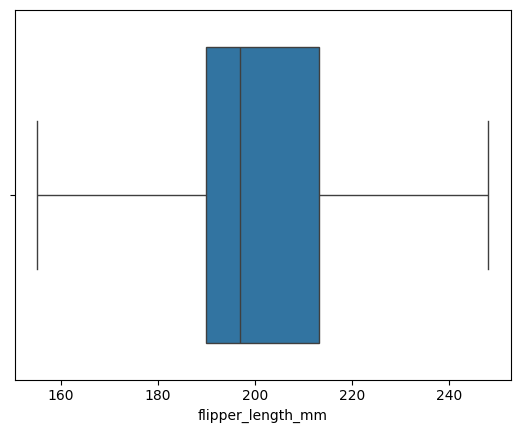

In [23]:
sns.boxplot(data=df, x='flipper_length_mm')
plt.show()

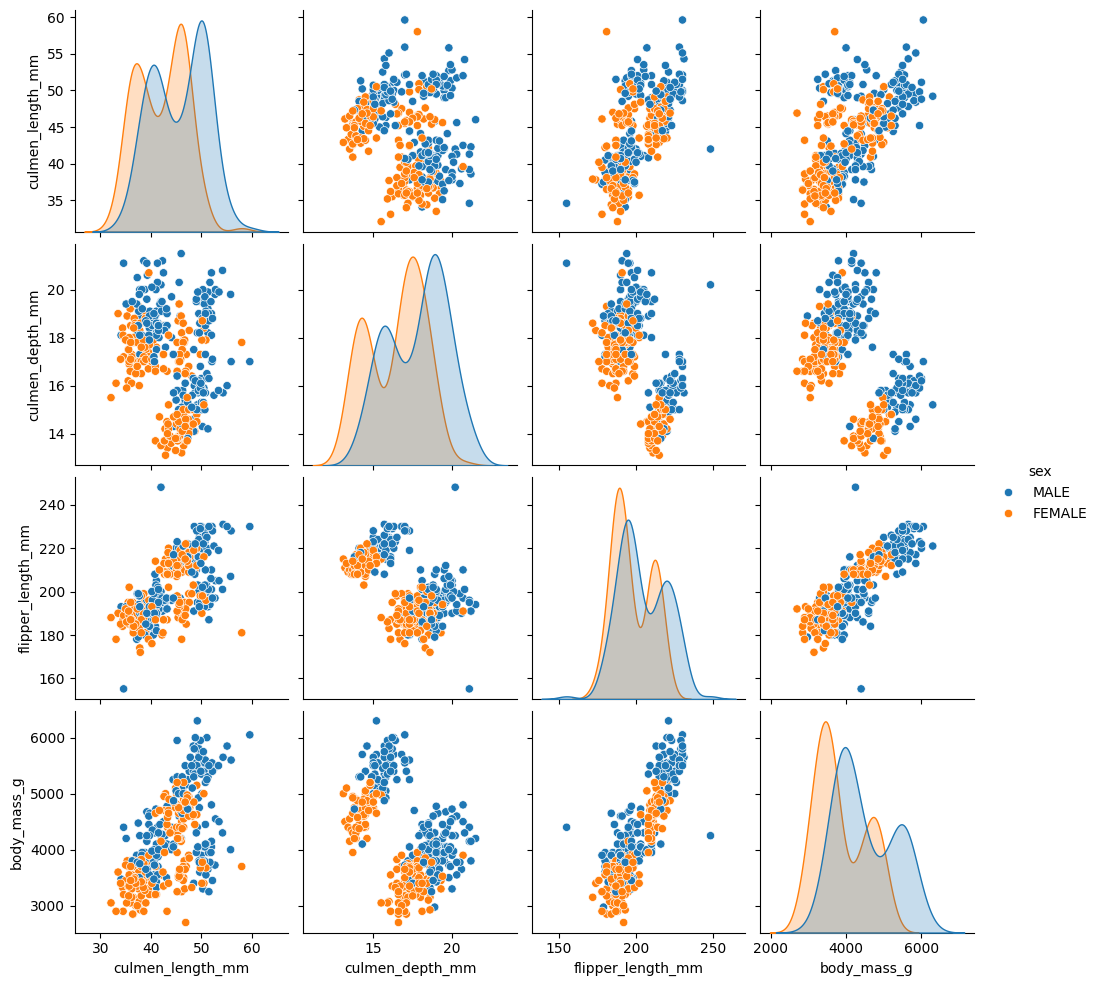

In [24]:
sns.pairplot(df, hue='sex')
plt.show()

## Проведем EDA после обработки

In [25]:
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.0,32.100,59.600,43.925000,44.45,29.634869,36.6,50.8,39.275,48.50
culmen_depth_mm,0.0,13.100,21.500,17.152035,17.30,3.877197,14.3,19.5,15.600,18.70
flipper_length_mm,0.0,155.125,248.125,200.936773,197.00,208.906432,185.0,221.0,190.000,213.25
body_mass_g,0.0,2700.000,6300.000,4200.872093,4050.00,639514.543359,3300.0,5400.0,3550.000,4750.00


In [26]:
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.0,2,MALE


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   344 non-null    float64
 1   culmen_depth_mm    344 non-null    float64
 2   flipper_length_mm  344 non-null    float64
 3   body_mass_g        344 non-null    float64
 4   sex                344 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


Пропуски и выбросы обработаны.

## Построим матрицу корреляции

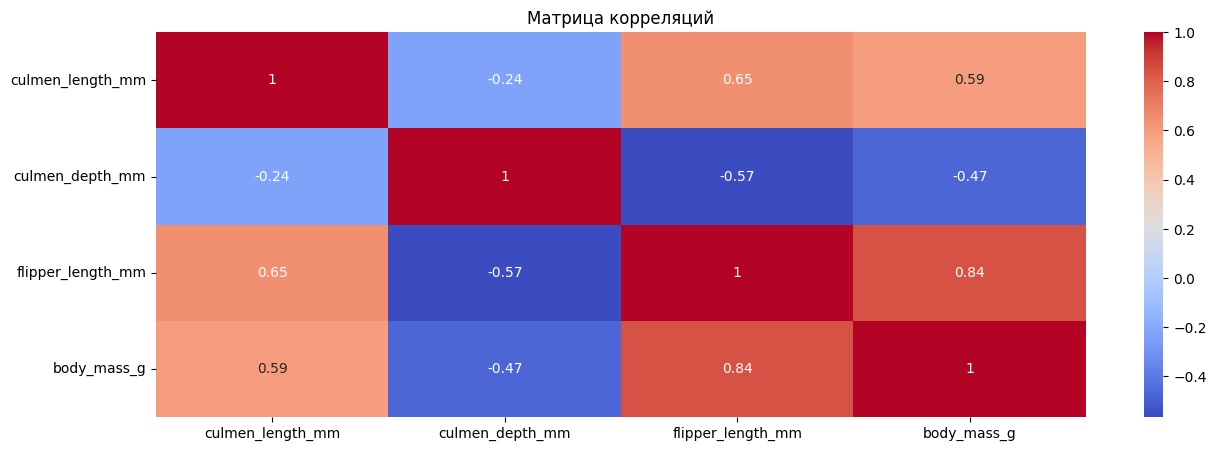

In [28]:
corr = df[col_num].corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Матрица корреляций")
plt.show()

Видим хорошую корреляцию между `flipper_length_mm и body_mass_g`, а также между `flipper_length_mm и culmen_length_mm`.

## Нормализация данных

In [29]:
# Нормализация данных
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[col_num] = scaler.fit_transform(df_scaled[col_num])
pd.DataFrame(df_scaled).head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.887622,0.787289,-1.381374,-0.564625,MALE
1,-0.814037,0.126114,-1.034935,-0.502010,FEMALE
2,-0.666866,0.431272,-0.411345,-1.190773,FEMALE
3,0.096581,0.075255,-0.272770,-0.188936,MALE
4,-1.329133,1.092447,-0.549921,-0.940314,FEMALE


## Кластеризация - AgglomerativeClustering

In [30]:
# Подбор гиперпараметров AgglomerativeClustering
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

best_score = -1
best_params = None

for n_clusters in param_grid['n_clusters']:
    for linkage_method in param_grid['linkage']:
        for metric in param_grid['metric']:
            if linkage_method == 'ward' and metric != 'euclidean':
                continue  # Ward linkage работает только с евклидовой метрикой
            clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            cluster_labels = clustering.fit_predict(df_scaled[col_num])
            score = silhouette_score(df_scaled[col_num], cluster_labels)
            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'linkage': linkage_method, 'metric': metric}

print(f'Лучшие параметры AgglomerativeClustering: {best_params}, Силуэтный коэффициент: {best_score:.2f}')


Лучшие параметры AgglomerativeClustering: {'n_clusters': 2, 'linkage': 'ward', 'metric': 'euclidean'}, Силуэтный коэффициент: 0.53


Силуэтный коэффициент (Silhouette Score) – это метрика, используемая для оценки качества кластеризации. Он измеряет, насколько хорошо объект внутри кластера схож с объектами своего кластера по сравнению с объектами других кластеров.

*Интерпретация значений:*

- Близкий к 1 → Хорошая кластеризация, объекты чётко принадлежат своим кластерам.
- Около 0 → Объекты находятся на границе между кластерами, возможно, есть пересечение.
- Отрицательный (< 0) → Плохая кластеризация, объекты могут быть отнесены не к своим кластерам.

У нас получилось не самое лучшее значение силуэтного коэффициента - 0.53

## Построение дендрограммы

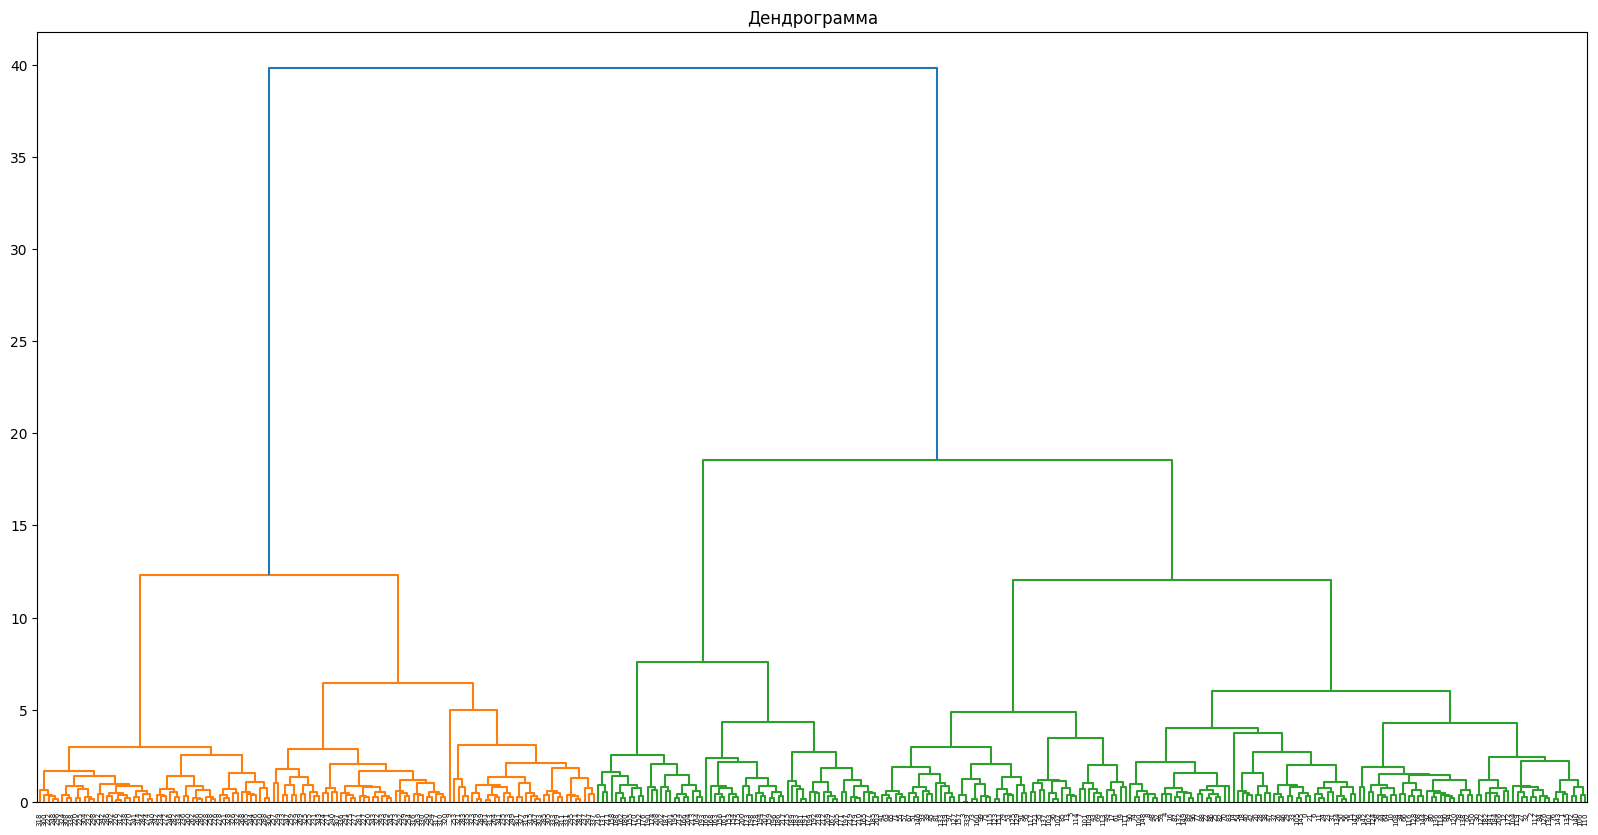

In [31]:
linked = linkage(df_scaled[col_num], method='ward')
plt.figure(figsize=(20, 10))
dendrogram(linked)
plt.title("Дендрограмма")
# Сохранение графика в формате PNG
plt.savefig("dendrogram.png", dpi=300, bbox_inches='tight', format='png')
plt.show()

Дендрограмма — это дерево кластеров, которое показывает, как объединяются объекты в процессе иерархической кластеризации.

Основные элементы дендрограммы:
- Ось X: объекты данных, отсортированные по порядку кластеризации.
- Ось Y: уровень расстояния (или несходства) при объединении кластеров.
- Ветви (dendrogram linkage): соединяют объекты и кластеры. Чем выше соединение, тем дальше (менее схожи) объекты.
- Высота соединений: чем выше уровень соединения двух кластеров, тем больше между ними разница.

## Сохранение лучшей модели

In [32]:
# Сохранение модели
final_model = AgglomerativeClustering(**best_params)
final_model.fit(df_scaled[col_num])
joblib.dump(final_model, 'agglomerative_model.joblib')

['agglomerative_model.joblib']

## Кластеризация по полу (столбец `sex`)

In [33]:
df_sex = df.copy()
df_sex['sex'] = df_sex['sex'].map({'MALE': 0, 'FEMALE': 1})
df_sex.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10,18.7,181.0,3750.0,0
1,39.50,17.4,186.0,3800.0,1
2,40.30,18.0,195.0,3250.0,1
3,44.45,17.3,197.0,4050.0,0
4,36.70,19.3,193.0,3450.0,1


In [34]:
df_sex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   344 non-null    float64
 1   culmen_depth_mm    344 non-null    float64
 2   flipper_length_mm  344 non-null    float64
 3   body_mass_g        344 non-null    float64
 4   sex                344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


In [35]:
df_sex['sex'].value_counts()

sex
0    179
1    165
Name: count, dtype: int64

In [36]:
df['sex'].value_counts()

sex
MALE      179
FEMALE    165
Name: count, dtype: int64

In [37]:
df_sex[col_num] = scaler.fit_transform(df_sex[col_num])

In [38]:
# Подбор гиперпараметров AgglomerativeClustering для кластеризации по полу
best_ari = -1
best_sex_params = None

for linkage_method in ['ward', 'complete', 'average', 'single']:
    for metric in ['euclidean', 'manhattan', 'cosine']:
        if linkage_method == 'ward' and metric != 'euclidean':
            continue  # Ward linkage работает только с евклидовой метрикой
        clustering_sex = AgglomerativeClustering(n_clusters=2, linkage=linkage_method, metric=metric)
        cluster_labels_sex = clustering_sex.fit_predict(df_sex[col_num])
        ari_score = adjusted_rand_score(df_sex['sex'], cluster_labels_sex)
        
        if ari_score > best_ari:
            best_ari = ari_score
            best_sex_params = {'n_clusters': 2, 'linkage': linkage_method, 'metric': metric}

print(f'Лучшие параметры AgglomerativeClustering для пола: {best_sex_params}, Adjusted Rand Index: {best_ari:.4f}')

Лучшие параметры AgglomerativeClustering для пола: {'n_clusters': 2, 'linkage': 'complete', 'metric': 'manhattan'}, Adjusted Rand Index: 0.0029


Метрика `Adjusted Rand Index (ARI)` оценивает, насколько хорошо результаты кластеризации совпадают с истинными метками классов. Она является улучшенной версией *Rand Index*, которая учитывает случайное совпадение кластеров.

**Интерпретация ARI:**

- ARI = 1 → идеальное совпадение кластеров с истинными метками.
- ARI ≈ 0 → результаты кластеризации близки к случайному распределению.
- ARI < 0 → хуже случайного разбиения (редкий случай).

В контексте нашего задания ARI используется для оценки, насколько хорошо алгоритм *AgglomerativeClustering* классифицирует пингвинов по полу. Низкое, практически равное нулю значение ARI означает, что кластеризация плохо разделяет самцов и самок.

## DBSCAN

In [39]:
# Подбор гиперпараметров DBSCAN
best_eps = None
best_min_samples = None
best_silhouette = -1

for eps in np.arange(0.1, 2.0, 0.1):
    for min_samples in range(2, 15): 
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_scaled[col_num])
        
        unique_labels = set(labels)
        num_clusters = len(unique_labels) - (1 if -1 in labels else 0)
        
        if num_clusters > 1:  # Игнорируем случаи, когда все точки попали в один кластер или выбросы
            silhouette = silhouette_score(df_scaled[col_num], labels)

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = round(eps, 2)
                best_min_samples = min_samples

if best_eps is None:
    print("DBSCAN не смог найти подходящие параметры.")
else:
    print(f'Лучшие параметры DBSCAN: eps={best_eps}, min_samples={best_min_samples}, Силуэтный коэффициент: {best_silhouette:.4f}')



Лучшие параметры DBSCAN: eps=0.9, min_samples=7, Силуэтный коэффициент: 0.5201


Силуэтный коэффициент также не самый высокий.

In [40]:
# Финальная модель DBSCAN
final_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df_scaled['cluster_dbscan'] = final_dbscan.fit_predict(df_scaled[col_num])

In [41]:
df_scaled['cluster_dbscan'].value_counts()

cluster_dbscan
 0    218
 1    122
-1      4
Name: count, dtype: int64

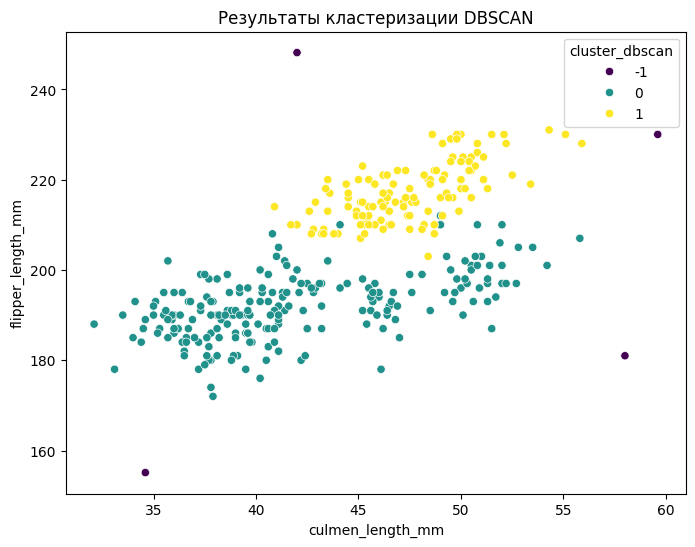

In [42]:
# Визуализация кластеров
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['culmen_length_mm'], y=df['flipper_length_mm'], hue=df_scaled['cluster_dbscan'], palette='viridis')
plt.title("Результаты кластеризации DBSCAN")
plt.show()

В алгоритме `DBSCAN` метка -1 обозначает выбросы или шум (то есть точки, которые не принадлежат ни одному кластеру). Это означает, что `DBSCAN` не смог включить эти точки в кластеры, поскольку они не соответствовали критериям *eps* (радиус соседства) и *min_samples* (минимальное количество точек для образования плотного региона).

Чтобы уменьшить количество выбросов, можно:

- Увеличить *eps* – расширить радиус поиска соседей.
- Уменьшить *min_samples* – снизить требуемое число точек для образования кластера.

Но если шумовые точки действительно выделяются (например, выбросы в данных), то их исключение может быть полезным.